# Opening an Ice Cream Shop in NYC - Battle of the Neighborhoods
### IBM Data Science Professional Certificate Capstone Course - Coursera
### Elizabeth P.
Date: 4/4/2021

Load and Import Libraries

In [1]:
!pip install bs4
!pip install geopandas
!pip install geopy
print("\n------All libraries installed------")


------All libraries installed------


In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json

import folium
from folium import plugins


import geopandas
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon
from geopy import distance, units
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans 

print("All libraries imported")

All libraries imported


### The Neighborhoods

First, we will import the json file of the approximate longitude/latitude centers of each neighborhood in New York City and then filter the data for the neighborhoods only located in Manhattan. These coordinates will later be used to make calls to the Foursquare API and gives us a general idea of which neighborhoods the venues are located near.

In [3]:
# open json file contain neighborhoods in nyc
with open('newyork_data.json') as json_data:
    nyc_neighb_json = json.load(json_data)
    
nyc_neighb_json['features'][0] 

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Next, we'll create a dataframe to view all the neighborhoods in Manhattan

In [4]:
# Creating a datafame of just the neighborhoods in Manhattan

# create columns for dataframe:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

manh_df = pd.DataFrame(columns = column_names)

# adding borough, neighborhood, lat, long to dataframe
for i, value in enumerate(nyc_neighb_json['features']):
    if nyc_neighb_json['features'][i]['properties']['borough'] == 'Manhattan':
        borough = 'Manhattan'
        neighborhood = nyc_neighb_json['features'][i]['properties']['name']
        lat = nyc_neighb_json['features'][i]['geometry']['coordinates'][1]
        long = nyc_neighb_json['features'][i]['geometry']['coordinates'][0]
        
        manh_df = manh_df.append({'Borough': borough,
                                  'Neighborhood': neighborhood,
                                  'Latitude': lat,
                                  'Longitude': long}, ignore_index=True)
        
manh_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [5]:
# make a tuple of latitude and longitude coordinates for each neighborhood
manh_coords = []

for neighborhood, n_lat, n_long in zip(manh_df.Neighborhood, manh_df.Latitude, manh_df.Longitude):
    manh_coords.append((neighborhood, n_lat, n_long))

Before we make calls to the Foursquare API, we'll make a function that sends requests to the Foursquare API and creates a list of the results.

   **NOTE:** Using the Foursquare API requires making an account and using a personal ID and passcode or access token. 

   *Personal Foursquare API information was removed before publishing*

In [6]:
# Foursquare Access Token and Version
ACCESS_TOKEN = 'UDNSUBMLFAQ32IAQ3UUYCEGMPDFIF4VLLPEZPJA5JRQNQK1Z'
VERSION = '20180604'

In [7]:
def getCategoryVenues(access_token, version, neighborhood, latitude, longitude, categoryID, radius=250, limit = 100):
    """
    function returns list of tuples that contain venue ID, venue name, venue latitude, venue longitude, category type, 
    neighborhood, neighborhood latitude, and neighborhood longitude
 
    """
    # create empty list for resulting venue information
    venues_list = []
    
    try:
        url = 'https://api.foursquare.com/v2/venues/search?oauth_token={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(access_token,
                                                                                                                                 version,
                                                                                                                                 latitude,
                                                                                                                                 longitude,
                                                                                                                                 categoryID,
                                                                                                                                 radius,
                                                                                                                                 limit)
    
        results = requests.get(url).json()
        
        # add venue inforamtion to venues_list
        for i, value in enumerate(results['response']['venues']):
            venues_list.append((results['response']['venues'][i]['id'],
                                results['response']['venues'][i]['name'],
                                results['response']['venues'][i]['location']['lat'],
                                results['response']['venues'][i]['location']['lng'],
                                results['response']['venues'][i]['categories'][0]['name'],
                                neighborhood,
                                latitude,
                                longitude))
            
        return (venues_list)

    except:
        print("\n--ERROR--\nCheck if function parameters are correctly entered and url is properly formatted\n")
        print(results)


### Finding Parks and Plazas

Ideally, we want our ice cream shop to be close to parks and plazas because people tend to gather and spend time relaxing there. Our clients hope that being near these locations will attract more customers to their shop.

We will narrow the results to feature only major parks, plazas, and pedestrian plazas

Foursquare category ID for outdoor venues:
    
    Outdoor and Recreation ID: 4d4b7105d754a06377d81259
    
If calls to the Foursquare API can't be made. A csv file of the results called *'outdoors.csv'* can be imported. This csv file contains the results from the API and has been cleaned.

In [8]:
# getting results of all outdoor venues from Foursquare API
try:
    outdoor_venues_list = []

    # get all outdoor locations 1000 m from each neighborhood center
    print("Retreiving Venues...")
    for place in manh_coords:
        neighb = place[0]
        lat = place[1]
        long = place [2]
        categoryID = "4d4b7105d754a06377d81259"
        outdoor_venues_list.append(getCategoryVenues(ACCESS_TOKEN, VERSION, neighb, lat, long, categoryID, radius = 1000))
       
    # creating dataframe of all the results from the Foursquare API
    outdoors_df = pd.DataFrame([venue for venues_list in outdoor_venues_list for venue in venues_list])
    outdoors_df.columns = ['venue_id',
                           'venue_name',
                           'venue_lat', 
                           'venue_long',
                           'venue_category',
                           'neighborhood',
                           'neighb_lat',
                           'neighb_long']
    print("\n--All Done--\n")
except:
    # read 'outdoors.csv' if API call doesn't work
    print("Error with API -- csv file will be used instead")
    try:
        outdoors_df = pd.read_csv('outdoors.csv')
    except:
        print('ERROR -- no csv file found')
    
print("{} venues found".format(outdoors_df.shape[0]))
outdoors_df.head()

Retreiving Venues...

--All Done--

1814 venues found


,venue_id,venue_name,venue_lat,venue_long,venue_category,neighborhood,neighb_lat,neighb_long
0,50b42dcce4b0daa7bcda4c9f,Riverdale,40.884370,-73.912760,General Travel,Marble Hill,40.876551,-73.91066
1,4bc23af3461576b04f197d32,Broadway Bridge,40.873650,-73.911067,Bridge,Marble Hill,40.876551,-73.91066
2,49fe029cf964a5205d6f1fe3,Inwood Hill Park,40.870858,-73.920129,Park,Marble Hill,40.876551,-73.91066
3,4aa00bcdf964a520103e20e3,Planet Fitness,40.874088,-73.909137,Gym / Fitness Center,Marble Hill,40.876551,-73.91066
4,4b12e631f964a5206d9023e3,Henry Hudson Bridge,40.877725,-73.922260,Bridge,Marble Hill,40.876551,-73.91066


In [9]:
# check for nulls and duplicates
print("Null values:")
print(outdoors_df.isnull().sum(), "\n")
print("Number of duplicates:", sum(outdoors_df.duplicated(subset='venue_id')))

# drop duplicate venues
outdoors_df.drop_duplicates(subset='venue_id', inplace = True, ignore_index = True)

print("\nThere are {} total venues found after removing duplicates".format(outdoors_df.shape[0]))

Null values:
venue_id          0
venue_name        0
venue_lat         0
venue_long        0
venue_category    0
neighborhood      0
neighb_lat        0
neighb_long       0
dtype: int64 

Number of duplicates: 935

There are 879 total venues found after removing duplicates


In [10]:
# check the types of categories that are considered 'outdoor'
outdoors_df['venue_category'].value_counts()

Park                    166
Gym / Fitness Center    110
Gym                      91
Playground               67
Bridge                   43
                       ... 
Hill                      1
Office                    1
General Travel            1
Boat or Ferry             1
Ski Area                  1
Name: venue_category, Length: 88, dtype: int64

We'll narrow results to just parks, plazas, and other park-like venues

In [11]:
# creating new df of just the parks and plazas in manhattan 
categories = ['Park', 'Plaza', 'Pedestrian Plaza']
all_parks_plazas = outdoors_df[outdoors_df.venue_category.isin(categories)]

print(all_parks_plazas.shape)
all_parks_plazas.head()

(206, 8)


,venue_id,venue_name,venue_lat,venue_long,venue_category,neighborhood,neighb_lat,neighb_long
2,49fe029cf964a5205d6f1fe3,Inwood Hill Park,40.870858,-73.920129,Park,Marble Hill,40.876551,-73.91066
11,4c58d06dec2520a1e4bf4d12,Henry Hudson Memorial Park,40.880748,-73.919190,Park,Marble Hill,40.876551,-73.91066
12,4c7510ae604a370409858149,Ewen Park,40.881735,-73.909973,Park,Marble Hill,40.876551,-73.91066
15,4ff611a3e4b0d27dd72f8525,Barnhill Triangle,40.868534,-73.901671,Park,Marble Hill,40.876551,-73.91066
16,52dd52bb498e35b966482afb,Muscota Marsh,40.873152,-73.918537,Park,Marble Hill,40.876551,-73.91066


There are a lot of parks and plazas, so we will further filter this list to contain only major parks, we can focus on the most popular areas. To find the bigger parks we'll look at the featured parks in Manhattan according to the NYC Department of Parks and Rec.

Scrape NYC Parks site for featured parks to narrow down to major parks: https://www.nycgovparks.org/park-features/parks-list?boro=M

In [12]:
m_parks_url = 'https://www.nycgovparks.org/park-features/parks-list?boro=M'
parks_data = requests.get(m_parks_url).text

In [13]:
parks_soup = BeautifulSoup(parks_data, 'html5lib')
featured_parks = parks_soup.find(id = 'boro-park-highlights')

# make an empty list to put all the featured parks in manhattan
featured_parks_list = []

# scrapping the list on the 'featued parks' section of the webpage and adding to list
for list_point in featured_parks.find_all('li'):
    for anchor in list_point.find('a'):
        featured_parks_list.append(anchor)

print(len(featured_parks_list), "featured parks")
featured_parks_list

31 featured parks


['Bowling Green',
 'Bryant Park',
 'Central Park',
 'City Hall Park',
 'De Witt Clinton Park',
 'East River Waterfront Esplanade',
 'Fort Tryon Park',
 'Fort Washington Park',
 'Harlem River Park',
 'Holcombe Rucker Park',
 'Imagination Playground',
 'Inwood Hill Park',
 'Isham Park',
 'J. Hood Wright Park',
 'Jackie Robinson Park',
 'Madison Square Park',
 'Marcus Garvey Park',
 'Morningside Park',
 "Randall's Island Park",
 'Riverside Park',
 'Riverside Park South',
 'Sara D. Roosevelt Park',
 'Seward Park',
 'St. Nicholas Park',
 'Stuyvesant Square',
 'The Battery',
 'The High Line',
 'Thomas Jefferson Park',
 'Tompkins Square Park',
 'Union Square Park',
 'Washington Square Park']

Some of the parks are formatted differently between the foursqare results and the NYC Dept of Parks and Rec. site. So, we'll find which parks that are featured on the Parks Department site don't appear in the foursquare results, so we can keep the ones that appear in both but are spelled or formatted differently

In [14]:
# look for the featured parks that are not listed in parks venues from the foursquare data
matches = all_parks_plazas[all_parks_plazas.venue_name.isin(featured_parks_list)]
match_parks = matches.venue_name.to_list()

no_matches = (list(set(featured_parks_list) - set(match_parks))) 
no_matches

["Randall's Island Park",
 'Sara D. Roosevelt Park',
 'J. Hood Wright Park',
 'Stuyvesant Square',
 'Imagination Playground',
 'Holcombe Rucker Park',
 'Marcus Garvey Park',
 'De Witt Clinton Park',
 'Harlem River Park',
 'The High Line',
 'The Battery',
 'Fort Washington Park']

The NYC Department of Transportation created a program that works with selected organizations to create neighborhood plazas throughout the City to transform underused streets social public spaces. The geojson file for these Pedestrain Plazas are available on the NYC Open Data site. We will also use these locations to help choose ideal locations for our ice cream shops

In [15]:
# open the geojson file of NYC DOT pedestrain plazas
with open ('NYC DOT Pedestrian Plazas.geojson') as fhandle:
    plaza_geojson = json.load(fhandle)

In [16]:
# import geojson of NYC DOT Pedestrian Plazas
all_ped_plaza = GeoDataFrame.from_file('NYC DOT Pedestrian Plazas.geojson')

# filtering into plazas only in Manhattan and find the centers of each plaza
manh_ped_plaza = all_ped_plaza[all_ped_plaza['boroname'] == 'Manhattan']
manh_ped_plaza = manh_ped_plaza[['onstreet', 'boroname', 'plazaname', 'geometry']].reset_index(drop=True)

manh_ped_plaza['center_lat'] = manh_ped_plaza.geometry.apply(lambda p: p.centroid.y)
manh_ped_plaza['center_long'] = manh_ped_plaza.geometry.apply(lambda p: p.centroid.x)
manh_ped_plaza.head(2)

,onstreet,boroname,plazaname,geometry,center_lat,center_long
0,Park Avenue (west),Manhattan,Pershing Square Plaza,"MULTIPOLYGON (((-73.97811 40.75164, -73.97814 ...",40.751837,-73.978066
1,Astor Place,Manhattan,Astor Place Plaza,"MULTIPOLYGON (((-73.99090 40.72966, -73.99090 ...",40.729807,-73.991085


In [17]:
# finding plazas that overlap in the DOT plazas and all_parks_plazas
for venue in all_parks_plazas.venue_name:
    if manh_ped_plaza.plazaname.str.contains(venue).any():
        print(venue)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Johnny Hartman Plaza
Columbus Circle
Times Square
Herald Square
Astor Place


In [18]:
# missing parks that are in the all_parks_plaza.csv, also adding popular other popular parks and plazas

other_places = ['Sara Delano Roosevelt Park', 'Jay Hood Wright Park', 'DeWitt Clinton Park', 'High Line', 'Battery Park',
                'Battle of Fort Washington Commemoration', 'Oculus Plaza', 'Waterfront Plaza, Brookfield Place', 'Hudson River Park',
                'Pier 25 - Hudson River Park',  'Pier 45 - Hudson River Park', 'Pier 63 - Hudson River Park', 
                'Pier 66 - Hudson River Park', 'Chelsea Park', 'Central Park - 99th & 5th Ave',
                'Central Park West - W 86th St', 'Central Park West- W 72nd St', 'Central Park - Harlem Hill',
                'Central Park South Gate House']

other_cat = ['Pedestrian Plaza']

We'll make a final dataframe of the parks and plazas of interest that we can use alongside the NYC DOT Pedestrian Plazas

In [19]:
mparks_df = all_parks_plazas[all_parks_plazas.venue_name.isin(featured_parks_list) | all_parks_plazas.venue_name.isin(other_places) | all_parks_plazas.venue_category.isin(other_cat)]
print("There are {} parks/plazas and {} NYC DOT plazas".format(mparks_df.shape[0], manh_ped_plaza.shape[0]))

There are 39 parks/plazas and 31 NYC DOT plazas


View parks and plazas on a map

In [20]:
# NYC latitude/longitude coordinates
NYC_LAT = 40.7600
NYC_LONG = -74.0000

In [21]:
parks_plazas_map = folium.Map(location = [NYC_LAT, NYC_LONG], zoom_start = 11.5)

folium.TileLayer('cartodbpositron').add_to(parks_plazas_map)

style_function = lambda x: {'fillColor': 'green', 'color':'green'}

for i, plaza in enumerate(plaza_geojson['features']):
    if plaza_geojson['features'][i]['properties']['boroname'] == 'Manhattan':
        name = plaza_geojson['features'][i]['properties']['plazaname']
        gjson = folium.GeoJson(plaza_geojson['features'][i], style_function=style_function)
        folium.Popup(name, parse_html = True).add_to(gjson)
        gjson.add_to(parks_plazas_map)

for lat, long, name in zip(mparks_df.venue_lat, mparks_df.venue_long, mparks_df.venue_name):
    folium.CircleMarker(
    [lat, long],
    radius = 3,
    color = 'green',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.5,
    popup = folium.Popup(name, parse_html = True)).add_to(parks_plazas_map)

parks_plazas_map

### Finding the Competition

Our next step is to find where the competition is. The ice cream shop's competitors are likely to be other dessert-like foods. We will use the Foursquare API to find venues within 1000 meters of each neighborhood center. The type of venues we will make queries for are dessert shops (which include ice cream shops), bakeries, and donut shops. 

These are the Foursquare category IDs for each type of venue we want to search for:

    bakeries --- 4bf58dd8d48988d16a941735

    dessert shops --- 4bf58dd8d48988d1d0941735 (includes ice cream shops)

    donut shops --- 4bf58dd8d48988d148941735

In [22]:
# getting competing venuese from Foursquare API and put results in dataframe
try:  
    competition_list = []

    # get the venues in each category for each neighborhood
    print("Retreiving Venues...")
    for place in manh_coords:
        neighb = place[0]
        lat = place[1]
        long = place [2]
        categoryID = ['4bf58dd8d48988d16a941735', '4bf58dd8d48988d1d0941735', '4bf58dd8d48988d148941735']
        for cat in categoryID:
            competition_list.append(getCategoryVenues(ACCESS_TOKEN, VERSION, neighb, lat, long, cat, radius = 1000))
        
    # creating a dataframe of the resulting venues
    competition_df = pd.DataFrame([venue for venues_list in competition_list for venue in venues_list])
    competition_df.columns = ['venue_id',
                              'venue_name',
                              'venue_lat',
                              'venue_long',
                              'venue_category',
                              'neighborhood',
                              'neighb_lat',
                              'neighb_long']
    print("\n--All Done--\n")

except:
    # read in 'all_competition.csv' if Foursquare API doesn't work
    print("Error with API -- csv file will be used instead")
    try:
        competition_df = pd.read_csv('all_competition.csv')
    except:
        print("ERROR -- no csv file found")
    
print("{} venues found".format(competition_df.shape[0]))
competition_df.head()

Retreiving Venues...

--All Done--

3950 venues found


,venue_id,venue_name,venue_lat,venue_long,venue_category,neighborhood,neighb_lat,neighb_long
0,4e01d7a41838cb6a1acf1be5,Franco #2 Bakery,40.874975,-73.909381,Food,Marble Hill,40.876551,-73.91066
1,516eb327e4b08ec9757fbb0e,Rosarina Bakery (aka Franco Bakery),40.874870,-73.909398,Bakery,Marble Hill,40.876551,-73.91066
2,4b3a968ff964a520846a25e3,Cafeccino Bakery,40.880209,-73.906884,Bagel Shop,Marble Hill,40.876551,-73.91066
3,4e51219062e14b77e3b32dfc,Corner Cafe And Bakery,40.887248,-73.906822,Bakery,Marble Hill,40.876551,-73.91066
4,5802a20c38fa8638a305e241,Auntie Anne's,40.877400,-73.904947,Bakery,Marble Hill,40.876551,-73.91066


In [23]:
# check for nulls and duplicates
print(competition_df.isnull().sum(), "\n")
print("Number of duplicates:", sum(competition_df.duplicated(subset='venue_id')))

competition_df.drop_duplicates(subset='venue_id', inplace = True, ignore_index = True)

print("\nThere are {} total venues found".format(competition_df.shape[0]))

venue_id          0
venue_name        0
venue_lat         0
venue_long        0
venue_category    0
neighborhood      0
neighb_lat        0
neighb_long       0
dtype: int64 

Number of duplicates: 2566

There are 1384 total venues found


In [24]:
# see all the different types of venues
pd.set_option('display.max_rows', None)
competition_df['venue_category'].value_counts()

Bakery                           475
Donut Shop                       229
Ice Cream Shop                   218
Dessert Shop                     168
Café                              57
Cupcake Shop                      44
Frozen Yogurt Shop                30
Coffee Shop                       23
Chocolate Shop                    16
Food Truck                        14
Candy Store                       11
American Restaurant                8
French Restaurant                  7
Burger Joint                       7
Bubble Tea Shop                    6
Pastry Shop                        6
Bagel Shop                         5
Tea Room                           4
Italian Restaurant                 4
Snack Place                        4
Sandwich Place                     4
Pizza Place                        4
Pie Shop                           4
Chinese Restaurant                 3
Deli / Bodega                      3
Juice Bar                          3
Farmers Market                     2
G

In [25]:
pd.set_option('display.max_rows', 10)

Upon further examination of the dataset, we are going to remove venues that are classified as restaurants, pizza places, deli/bodegas, or non-dessert places; we are also going to remove all the Dunkin' donut places because they don't quite fit the type of competition

In [26]:
# categories to keep
filtered_cats = ['Bakery', 'Ice Cream Shop', 'Donut Shop', 'Dessert Shop', 'Coffee Shop', 'Cupcake Shop', 'Frozen Yogurt Shop',
                'Food Truck', 'Chocolate Shop', 'Candy Store', 'Pastry Shop', 'Pie Shop', 'Creperie', 'Gelato Shop']

# filter the competition to relevant competitors
competition_df = competition_df[competition_df.venue_category.isin(filtered_cats)]
competition_df = competition_df[competition_df.venue_name != "Dunkin'"]

print("There are {} competing venues".format(competition_df.shape[0]))

competition_df.head()

There are 1062 competing venues


,venue_id,venue_name,venue_lat,venue_long,venue_category,neighborhood,neighb_lat,neighb_long
1,516eb327e4b08ec9757fbb0e,Rosarina Bakery (aka Franco Bakery),40.874870,-73.909398,Bakery,Marble Hill,40.876551,-73.91066
3,4e51219062e14b77e3b32dfc,Corner Cafe And Bakery,40.887248,-73.906822,Bakery,Marble Hill,40.876551,-73.91066
4,5802a20c38fa8638a305e241,Auntie Anne's,40.877400,-73.904947,Bakery,Marble Hill,40.876551,-73.91066
5,58c98b327d66be63b1670c1e,Panaderia Ixtapan,40.879181,-73.905456,Bakery,Marble Hill,40.876551,-73.91066
6,4debd81822713dd973b85876,Sugarboy Bakery Cafe,40.877948,-73.902860,Bakery,Marble Hill,40.876551,-73.91066


### Finding Ideal Locations

To get a better sense of where the competition is let's show these venues on map along with the neighborhood boundaries. 


**NOTE:**

    Neighborhood boundries vary depending on the source. We will read in GeoJson file of the NYC neighborhood boundries provided by NYC  Dept. of City Planning (based on 2010 census data, 2020 census data not yet when this report was created)

In [27]:
# open the geojson file of NYC Neighborhoods (NTA)
with open ('Neighborhood Tabulation Areas (NTA).geojson') as fhandle:
    nta_geojson = json.load(fhandle)
    
nta_geojson['features'][0]['properties']

{'ntacode': 'BK88',
 'shape_area': '54005019.048',
 'county_fips': '047',
 'ntaname': 'Borough Park',
 'shape_leng': '39247.2278309',
 'boro_name': 'Brooklyn',
 'boro_code': '3'}

In [28]:
# mapping the individual locations of the competition
competition_map = folium.Map(location = [NYC_LAT, NYC_LONG], zoom_start = 11.5)

folium.TileLayer('cartodbpositron').add_to(competition_map)

style_function = lambda x: {'fill':False, 'color':'blue'}

for i, neighborhood in enumerate(nta_geojson['features']):
        if nta_geojson['features'][i]['properties']['boro_name'] == 'Manhattan':
            name = nta_geojson['features'][i]['properties']['ntaname']
            gjson = folium.GeoJson(nta_geojson['features'][i], style_function=style_function)
            folium.Popup(name, parse_html = True).add_to(gjson)
            gjson.add_to(competition_map)
    
for lat, long, name in zip(competition_df.venue_lat, competition_df.venue_long, competition_df.venue_name):
    folium.CircleMarker(
    [lat, long],
    radius = 3,
    color = 'red',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.5,
    popup = folium.Popup(name, parse_html = True)).add_to(competition_map)
    
competition_map

Let's also use a heatmap along with the neighborhood boundaries to get a better idea of high and low density areas.

In [29]:
# Converting lat and long of competitions to use in the heatmap
heat_data = competition_df[['venue_lat', 'venue_long']]

heat_data = [[row['venue_lat'],row['venue_long']] for index, row in competition_df.iterrows()]

In [30]:
#competition heatmap
compet_heatmap = folium.Map(location = [NYC_LAT, NYC_LONG], zoom_start = 11)

folium.TileLayer('cartodbpositron').add_to(compet_heatmap)

style_function = lambda x: {'fill':False, 'color':'blue'}

for i, neighborhood in enumerate(nta_geojson['features']):
        if nta_geojson['features'][i]['properties']['boro_name'] == 'Manhattan':
            name = nta_geojson['features'][i]['properties']['ntaname']
            gjson = folium.GeoJson(nta_geojson['features'][i], style_function=style_function)
            folium.Popup(name, parse_html = True).add_to(gjson)
            gjson.add_to(compet_heatmap)
            
plugins.HeatMap(heat_data).add_to(compet_heatmap)

compet_heatmap

After looking at the map, we want to narrow our ideal location to neighborhoods with lower competition and ones that are popular with both tourists and locals. We decided to narrow the neighborhoods to: 
- Battery Park City-Lower Manhattan
- Hudson Yards-Chelsea-Flatiron-Union Square
- West Village
- SoHo-TriBeCa-Civic Center-Little Italy
- Central Harlem South
- Central Harlem North-Polo Grounds

We will also filter the neighborhood center coordinates and the competition to those within these NTAs

In [31]:
# desired nta
desired_hoods = ['Battery Park City-Lower Manhattan', 'Hudson Yards-Chelsea-Flatiron-Union Square', 'West Village',
                'SoHo-TriBeCa-Civic Center-Little Italy', 'Central Harlem South', 'Central Harlem North-Polo Grounds']

# neighborhoods within the desired nta
desired_neighb = ['Battery Park City', 'Financial District', 'Civic Center', 'Tribeca', 'Little Italy', 'Soho', 
                  'Greenwich Village', 'West Village', 'Flatiron', 'Chelsea', 'Hudson Yards', 'Central Harlem', 
                  'Manhattan Valley', 'East Harlem']

In [32]:
# create geodataframe of chosen neighborhoods
all_nta = GeoDataFrame.from_file('Neighborhood Tabulation Areas (NTA).geojson')

chosen_nta = all_nta[all_nta['ntaname'].isin(desired_hoods)]
chosen_nta.reset_index(drop = True, inplace = True)
chosen_nta

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,MN25,19014298.8134,061,Battery Park City-Lower Manhattan,43738.4960413,Manhattan,1,"MULTIPOLYGON (((-74.00078 40.69429, -74.00096 ..."
1,MN03,25403484.2821,061,Central Harlem North-Polo Grounds,27983.8840398,Manhattan,1,"MULTIPOLYGON (((-73.93445 40.83598, -73.93456 ..."
2,MN13,37068381.8903,061,Hudson Yards-Chelsea-Flatiron-Union Square,45693.074601,Manhattan,1,"MULTIPOLYGON (((-74.00153 40.76264, -74.00134 ..."
3,MN23,24970650.149,061,West Village,28621.651152,Manhattan,1,"MULTIPOLYGON (((-73.98990 40.73443, -73.98987 ..."
4,MN11,14439304.7812,061,Central Harlem South,16621.0234443,Manhattan,1,"MULTIPOLYGON (((-73.94177 40.80709, -73.94226 ..."
5,MN24,25032681.6869,061,SoHo-TriBeCa-Civic Center-Little Italy,26855.0316688,Manhattan,1,"MULTIPOLYGON (((-73.99260 40.72414, -73.99263 ..."


We'll filter the competition to include those only in the desired neighborhoods

In [33]:
# filter the competition
final_competition = competition_df[competition_df['neighborhood'].isin(desired_neighb)]
final_competition.reset_index(drop=True, inplace=True)
print("There are {} competing venues".format(final_competition.shape[0]))

There are 314 competing venues


We'll make dot grid in the chosen neighborhoods so pockets of low competition could be better identified

In [34]:
all_coords = []
nta_names = []

# create a dot grid
for i, row in chosen_nta.iterrows():
    minx, miny, maxx, maxy = row['geometry'].bounds
    if row['ntaname'] == 'SoHo-TriBeCa-Civic Center-Little Italy' or row['ntaname'] == 'Central Harlem South' or row['ntaname'] == 'West Village':
        xx, yy = np.meshgrid(np.linspace(minx,maxx,10), np.linspace(miny,maxy,10))
    else:
        xx, yy = np.meshgrid(np.linspace(minx,maxx,10), np.linspace(miny,maxy,15))
        
    longs = xx.flatten()
    lats = yy.flatten()
    
    dots = GeoSeries([Point(long, lat) for long, lat in zip(longs, lats)])
    in_map =  np.array([dots.within(geom) for geom in row.geometry]).sum(axis=0)
    dots = GeoSeries([value for ind,value in enumerate(dots) if in_map[ind]])
    
    for i, (long, lat) in enumerate(zip(dots.x, dots.y)):
        all_coords.append((lat, long))
        nta_names.append(row['ntaname'])

In [35]:
# put lat/long of dots in to dataframe
dots_df = geopandas.GeoDataFrame(all_coords, columns = ['dot_lat', 'dot_long'])
dots_df['nta_name'] = nta_names

In [36]:
dots_df.head(5)

,dot_lat,dot_long,nta_name
0,40.697649,-74.000230,Battery Park City-Lower Manhattan
1,40.701230,-74.008421,Battery Park City-Lower Manhattan
2,40.701230,-73.997500,Battery Park City-Lower Manhattan
3,40.703020,-74.013882,Battery Park City-Lower Manhattan
4,40.703020,-74.011151,Battery Park City-Lower Manhattan


We want to identify areas with low number of competiting shops. So, we will classify these areas as dots with < 3 competiting shops in a radius of 150 meters

In [37]:
# count number of competiting shops in 150m radius of each dot
all_venue_counts = []

for i, (d_lat, d_long) in enumerate(zip(dots_df.dot_lat, dots_df.dot_long)):
    count = 0
    
    for ind, (v_lat, v_long) in enumerate(zip(final_competition.venue_lat, final_competition.venue_long)):
        dist = distance.distance((d_lat, d_long), (v_lat, v_long)).m
        if dist <= 150:
            count += 1
    dots_df.loc[i, 'nearby_venues'] = count


In [38]:
# filter dots to those that meet criteria
final_dots = dots_df[dots_df['nearby_venues'] < 3].reset_index(drop = True)
print("There are {} possible locations".format(final_dots.shape[0]))

There are 242 possible locations


Let's reverse geocode the coordinates to the get approximate addresses the candidate locations

In [39]:
# making a temporary column for the coordinates to use for reverse geocoding
for i, (lat, long) in enumerate(zip(final_dots.dot_lat, final_dots.dot_long)):
    d_lat = str(lat)
    d_long = str(long)
    final_dots.loc[i, 'coords'] = (d_lat +", " + d_long)

In [40]:
# reverse geocode for approximate addresses
geolocator = Nominatim(user_agent="my-geoapp")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
final_dots['approx_address'] = final_dots['coords'].apply(geocode)

In [41]:
# reorganize columns
final_dots.drop('coords', axis=1, inplace = True)
addr = final_dots.pop('approx_address')
final_dots.insert(0, 'approx_address', addr)

In [42]:
final_dots.head(5)

,approx_address,dot_lat,dot_long,nta_name,nearby_venues
0,"(Pier 3, Labrynth, Manhattan Community Board 1...",40.697649,-74.000230,Battery Park City-Lower Manhattan,0.0
1,"(Downtown Manhattan Heliport, East River Espla...",40.701230,-74.008421,Battery Park City-Lower Manhattan,0.0
2,"(Granite Prospect, DUMBO, Brooklyn, Kings Coun...",40.701230,-73.997500,Battery Park City-Lower Manhattan,0.0
3,"(17 State Street, State Street, Financial Dist...",40.703020,-74.013882,Battery Park City-Lower Manhattan,0.0
4,"(Water St & Broad St, Water Street, Financial ...",40.703020,-74.011151,Battery Park City-Lower Manhattan,2.0


Let's look at where these candidate locations in relation to the competition are using a heatmap of the competition.

In [43]:
# Converting lat and long of competitions to use in the heatmap
heat_data = final_competition[['venue_lat', 'venue_long']]

heat_data = [[row['venue_lat'],row['venue_long']] for index, row in final_competition.iterrows()]

In [44]:
candidate_heatmap = folium.Map(location = [NYC_LAT, NYC_LONG], zoom_start = 11)

folium.TileLayer('cartodbpositron').add_to(candidate_heatmap)

for i, (lat, long, address) in enumerate(zip(final_dots.dot_lat, final_dots.dot_long, final_dots.approx_address)):
    folium.CircleMarker(
    [lat, long],
    radius = 3,
    color = 'black',
    fill = True,
    fill_color = 'black',
    fill_opacity = 0.5,
    popup = folium.Popup(address, parse_html = True)).add_to(candidate_heatmap)
    
plugins.HeatMap(heat_data).add_to(candidate_heatmap)
    
candidate_heatmap

Ideally, we want our locations to be close to parks and plazas, so let's also calculate the distance from each candidate location to its closest park or plaza.

In [45]:
# calculate the distance between candidate dot and its closes park/plaza
closest_p = []
for i, (d_lat, d_long) in enumerate(zip(final_dots.dot_lat, final_dots.dot_long)):
    closest_place = []
    dist_list = []
    
    for c_lat, c_long, pl_name in zip(manh_ped_plaza.center_lat, manh_ped_plaza.center_long, manh_ped_plaza.plazaname):
        dist_list.append(distance.distance((d_lat, d_long), (c_lat, c_long)).m)
        closest_place.append(pl_name)
        
    for p_lat, p_long, pk_name in zip(mparks_df.venue_lat, mparks_df.venue_long, mparks_df.venue_name):
        dist_list.append(distance.distance((d_lat, d_long), (p_lat, p_long)).m)
        closest_place.append(pk_name)
    
    min_dist = min(dist_list)
    ind = dist_list.index(min(dist_list))
    
    closest = (min_dist, closest_place[ind])
    closest_p.append(closest)

In [46]:
# add distance to the candidate locations
for i, park in enumerate(closest_p):
    final_dots.loc[i, 'closest_parkplaza'] = park[1]
    final_dots.loc[i, 'distance_to_parkplaza (m)'] = park[0]
    
final_dots.head(5)

,approx_address,dot_lat,dot_long,nta_name,nearby_venues,closest_parkplaza,distance_to_parkplaza (m)
0,"(Pier 3, Labrynth, Manhattan Community Board 1...",40.697649,-74.000230,Battery Park City-Lower Manhattan,0.0,East River Esplanade,880.241765
1,"(Downtown Manhattan Heliport, East River Espla...",40.701230,-74.008421,Battery Park City-Lower Manhattan,0.0,Elevated Acre,227.820371
2,"(Granite Prospect, DUMBO, Brooklyn, Kings Coun...",40.701230,-73.997500,Battery Park City-Lower Manhattan,0.0,East River Esplanade,721.606471
3,"(17 State Street, State Street, Financial Dist...",40.703020,-74.013882,Battery Park City-Lower Manhattan,0.0,Water/Whitehall Plaza,128.810128
4,"(Water St & Broad St, Water Street, Financial ...",40.703020,-74.011151,Battery Park City-Lower Manhattan,2.0,Coenties Slip Plaza,76.204010


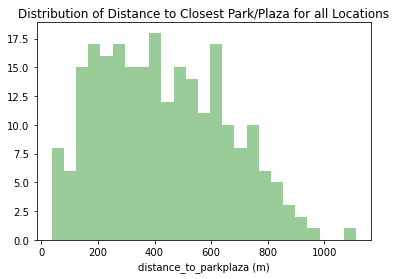

In [47]:
# plotting the distribution of distance to closest park/plaza
park_plaza_hist = sns.distplot(final_dots['distance_to_parkplaza (m)'], color = 'green', bins = 25, kde = False)
plt.title("Distribution of Distance to Closest Park/Plaza for all Locations")
plt.show()

In [48]:
# find the max and min distance to the closest park/plaza
min_dist_all = min(final_dots['distance_to_parkplaza (m)'])
max_dist_all = max(final_dots['distance_to_parkplaza (m)'])
med_dist_all = final_dots['distance_to_parkplaza (m)'].median()

print("The range of distance between location and park/plaza is between %.4f meters" %min_dist_all, "and %.4f meters" %max_dist_all)
print("The median distance is %.4f meters from a park or plaza" %med_dist_all)

The range of distance between location and park/plaza is between 37.0693 meters and 1112.0673 meters
The median distance is 411.2203 meters from a park or plaza


In [49]:
# creating a function to create barplot of how many candidate locations are in each NTA
def plot_top_nta(dataframe):
    '''
    create bar graph of how many candidate locations are in each NTA
    '''
    top_nta = dataframe['nta_name'].value_counts().to_frame().reset_index()
    top_nta.rename(columns={'index':'nta_name', 'nta_name':'location_dots'}, inplace = True)
    
    sns.barplot(x = 'location_dots', y = 'nta_name', data = top_nta, palette = 'magma')
    
    title = "Number of Candidate Locations by NTA"
    
    plt.title(label = title, size = 14)
    plt.xlabel("Count", size = 14)
    plt.ylabel("NTA Name", size = 14)

    for index, value in enumerate(top_nta['location_dots']):
        label = value
        plt.annotate(label, xy = (value+0.01, index+0.1))

    plt.show()

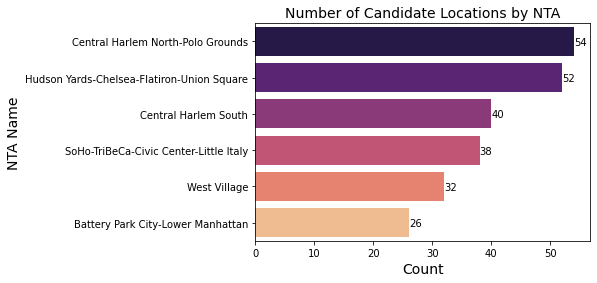

In [50]:
top_ntas = plot_top_nta(final_dots)


The graph above shows how many candidate locations are in each neighborhood. We can see that most of the candidate location are in 'Central Harlem North - Polo Grounds' and 'Hudson Yards-Chelsea-Flatiron-Union Square. 

Let's also cluster these potential locations using K-means clustering to see if we can group these locations further

In [51]:
X = final_dots.loc[:, ['dot_lat', 'dot_long', 'nearby_venues', 'distance_to_parkplaza (m)']]

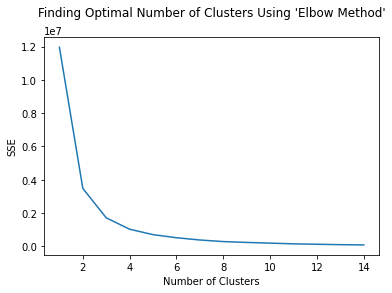

In [52]:
# determine number clusters to use
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k).fit(X)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Finding Optimal Number of Clusters Using 'Elbow Method'\n")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

It seems like the best number of clusters is 4 because this is were the inertia seems to begin decreasing approximately linearly. Let's re-fit the dataset with a cluster number of 4 and assign the cluster label to each dot.

In [53]:
k_cluster = 4

kmeans = KMeans(n_clusters=k_cluster).fit(X)

final_dots["cluster_number"] = kmeans.labels_

In [54]:
final_dots.head(5)

,approx_address,dot_lat,dot_long,nta_name,nearby_venues,closest_parkplaza,distance_to_parkplaza (m),cluster_number
0,"(Pier 3, Labrynth, Manhattan Community Board 1...",40.697649,-74.000230,Battery Park City-Lower Manhattan,0.0,East River Esplanade,880.241765,2
1,"(Downtown Manhattan Heliport, East River Espla...",40.701230,-74.008421,Battery Park City-Lower Manhattan,0.0,Elevated Acre,227.820371,1
2,"(Granite Prospect, DUMBO, Brooklyn, Kings Coun...",40.701230,-73.997500,Battery Park City-Lower Manhattan,0.0,East River Esplanade,721.606471,2
3,"(17 State Street, State Street, Financial Dist...",40.703020,-74.013882,Battery Park City-Lower Manhattan,0.0,Water/Whitehall Plaza,128.810128,1
4,"(Water St & Broad St, Water Street, Financial ...",40.703020,-74.011151,Battery Park City-Lower Manhattan,2.0,Coenties Slip Plaza,76.204010,1


Let's view these clusters on a map

In [ ]:
cluster_map = folium.Map(location = [NYC_LAT, NYC_LONG], zoom_start = 11)

folium.TileLayer('cartodbpositron').add_to(cluster_map)

colors = ["Orange", "Purple", "Blue", "Red"]
#x = np.arange(4)
#ys = [i + x + (i*x)**2 for i in range(4)]
#colors_array = cm.magma(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
        
for lat, long, name in zip(mparks_df.venue_lat, mparks_df.venue_long, mparks_df.venue_name):
    folium.Circle(
    [lat, long],
    radius = 250,
    color = 'green',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.1).add_to(cluster_map)
    
for lat, long, plname in zip(manh_ped_plaza.center_lat, manh_ped_plaza.center_long, manh_ped_plaza.plazaname):
    folium.Circle(
    [lat, long],
    radius = 250,
    color = 'green',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.1).add_to(cluster_map)
    
style_function = lambda x: {'fillColor': 'green', 'color':'green'}
    
for i, plaza in enumerate(plaza_geojson['features']):
        if plaza_geojson['features'][i]['properties']['boroname'] == 'Manhattan':
            name = plaza_geojson['features'][i]['properties']['plazaname']
            gjson = folium.GeoJson(plaza_geojson['features'][i], style_function=style_function)
            folium.Popup(name, parse_html = True).add_to(gjson)
            gjson.add_to(cluster_map)

for lat, long, name in zip(mparks_df.venue_lat, mparks_df.venue_long, mparks_df.venue_name):
        folium.CircleMarker(
        [lat, long],
        radius = 3,
        color = 'green',
        fill = True,
        fill_color = 'green',
        fill_opacity = 0.5,
        popup = folium.Popup(name, parse_html = True)).add_to(cluster_map)   

for i, (lat, long, address, cluster) in enumerate(zip(final_dots.dot_lat, final_dots.dot_long, final_dots.approx_address, final_dots.cluster_number)):
    label = folium.Popup((address, '- Cluster ' + str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        color= colors[cluster-1],
        fill=True,
        fill_color= colors[cluster-1],
        fill_opacity=0.7,
        popup= folium.Popup((address,'- Cluster', str(cluster)), parse_html=True)).add_to(cluster_map)
    
cluster_map

From looking at the map, it looks like the locations clustered based on distance to it's closest park, so let's take a closer look at which candidate locations belong to each cluster.

In [ ]:
# plotting the distribution of distance to each park based on cluster

plt.figure(figsize=(10,4))
ax = sns.boxplot(x='distance_to_parkplaza (m)', y='cluster_number', hue='cluster_number', data=final_dots, 
                 orient = 'h', 
                 dodge = False,
                palette = 'magma' )
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.title("Distribution of Distance to Closest Park", size = 14)
plt.xlabel("Distance to Closest Park/Plaza (m)", size = 12)
plt.ylabel("Cluster Number", size = 12)
plt.show()

### Cluster 0

In [ ]:
clust0 = final_dots.loc[final_dots['cluster_number'] == 0].reset_index(drop=True)
print("There are {} venues in Cluster 0".format(clust0.shape[0]))
clust0.head(5)

In [ ]:
# find the max and min distance to the closest park/plaza
min_dist0 = min(clust0['distance_to_parkplaza (m)'])
max_dist0 = max(clust0['distance_to_parkplaza (m)'])
med_dist0 = clust0['distance_to_parkplaza (m)'].median()

print("The range of distance between location and park/plaza is between %.4f meters" %min_dist0, "and %.4f meters for Cluster 0" %max_dist0)
print("The median distance is about %.4f meters from a park or plaza" %med_dist0)

In [ ]:
clust0_hist = sns.boxplot(clust0['distance_to_parkplaza (m)'], palette = 'magma')
plt.xlabel("Distance to Park/Plaza (m)")
plt.ylabel("Cluster 0")
plt.title("Distance to Closest Park/Plaza")
plt.show()

In [ ]:
clust0_nta = plot_top_nta(clust0)

### Cluster 1

In [ ]:
clust1 = final_dots.loc[final_dots['cluster_number'] == 1].reset_index(drop=True)
print("There are {} venues in Cluster 1".format(clust1.shape[0]))
clust1.head(5)

In [ ]:
# find the max and min distance to the closest park/plaza
min_dist1 = min(clust1['distance_to_parkplaza (m)'])
max_dist1 = max(clust1['distance_to_parkplaza (m)'])
med_dist1 = clust1['distance_to_parkplaza (m)'].median()

print("The range of distance between location and park/plaza is between %.4f meters" %min_dist1, "and %.4f meters for Cluster 1" %max_dist1)
print("The median distance is about %.4f meters from a park or plaza" %med_dist1)

In [ ]:
clust1_hist = sns.boxplot(clust1['distance_to_parkplaza (m)'], palette = 'magma')
plt.xlabel("Distance to Park/Plaza (m)")
plt.ylabel("Cluster 1")
plt.title("Distance to Closest Park/Plaza")
plt.show()

In [ ]:
clust1_nta = plot_top_nta(clust1)

### Cluster 2

In [ ]:
clust2 = final_dots.loc[final_dots['cluster_number'] == 2].reset_index(drop=True)
print("There are {} venues in Cluster 2".format(clust2.shape[0]))
clust2.head(5)

In [ ]:
# find the max and min distance to the closest park/plaza
min_dist2 = min(clust2['distance_to_parkplaza (m)'])
max_dist2 = max(clust2['distance_to_parkplaza (m)'])
med_dist2 = clust2['distance_to_parkplaza (m)'].median()

print("The range of distance between location and park/plaza is between %.4f meters" %min_dist2, "and %.4f meters for Cluster 2" %max_dist2)
print("The median distance is about %.4f meters from a park or plaza" %med_dist2)

In [ ]:
clust2_hist = sns.boxplot(clust2['distance_to_parkplaza (m)'], palette = 'magma')
plt.xlabel("Distance to Park/Plaza (m)")
plt.ylabel("Cluster 2")
plt.title("Distance to Closest Park/Plaza")
plt.show()

In [ ]:
clust2_nta = plot_top_nta(clust2)

### Cluster 3

In [ ]:
clust3 = final_dots.loc[final_dots['cluster_number'] == 3].reset_index(drop=True)
print("There are {} venues in Cluster 3".format(clust3.shape[0]))
clust3.head(5)

In [ ]:
# find the max and min distance to the closest park/plaza
min_dist3 = min(clust3['distance_to_parkplaza (m)'])
max_dist3 = max(clust3['distance_to_parkplaza (m)'])
med_dist3 = clust3['distance_to_parkplaza (m)'].median()

print("The range of distance between location and park/plaza is between %.4f meters" %min_dist3, "and %.4f meters for Cluster 3" %max_dist3)
print("The median distance is about %.4f meters from a park or plaza" %med_dist3)

In [ ]:
clust3_hist = sns.boxplot(clust3['distance_to_parkplaza (m)'], palette = 'magma')
plt.xlabel("Distance to Park/Plaza (m)")
plt.ylabel("Cluster 3")
plt.title("Distance to Closest Park/Plaza")
plt.show()

In [ ]:
clust3_nta = plot_top_nta(clust3)

### Discussion and Conclusion

From the results, it can be seen that the most locations are in the Harlem neighborhoods, however, these locations tend to be the further from a major park or plaza. From the heatmap and competition map, we can also see that the Harlem neighborhoods also have lower competition.


The downtown neighborhoods are closer to major parks and plazas, but have fewer candidate locations and more competition. Out of the neighborhoods that are downtown, ‘Hudson Yards – Chelsea – Flatiron – Union Square’ seems to have the most candidate locations in the two closest clusters to parks and plazas.

For an initial guide for picking a location to open a new ice cream shop, this report some candidate locations to begin exploration. There are candidate location in each of the neighborhoods that are both close to parks/plazas and have a low number of nearby competitors. 

Out of the potential neighborhoods that were chosen, it seems like the ‘Hudson Yards – Chelsea – Flatiron – Union Square’ NTA would be the best place to begin exploring. These neighborhoods have the most candidate locations and are in clusters that are the closer to major parks and plazas. 

Although the Harlem candidates tend to be further from major parks, they may be close to other venues of interest. In the more residential locations, being close to playgrounds, smaller public parks, or other high pedestrian traffic areas may help generate more exposure. 

Further exploration into characteristics of these locations and other types of venues should be included in the process. As always, other factors outside the scope of this report needs to be considered, such as rental/leasing prices and availability, proximity to public transport, etc.

### References

- https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
- https://developer.foursquare.com/docs/api-reference/venues/search/
- https://www.nycgovparks.org/park-features/parks-list?boro=M
- https://data.cityofnewyork.us/Transportation/NYC-DOT-Pedestrian-Plazas/k5k6-6jex